In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# DATA PREPARATION(MULTI LABEL)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


name: tensor([[[[ 2.2489,  2.2489,  2.2489,  ..., -0.4226, -0.3027, -0.4054],
          [ 2.2489,  2.2489,  2.2489,  ..., -0.4226, -0.2684, -0.2684],
          [ 2.2489,  2.2489,  2.2489,  ..., -0.3883, -0.4739, -0.6109],
          ...,
          [-0.7993, -0.7993, -0.7822,  ...,  0.7419,  0.7248,  0.7248],
          [-0.8164, -0.7822, -0.7822,  ...,  0.7077,  0.7077,  0.7077],
          [-0.8335, -0.7822, -0.7993,  ...,  0.7419,  0.7248,  0.7248]],

         [[ 2.4286,  2.4286,  2.4286,  ..., -0.7752, -0.6176, -0.6702],
          [ 2.4286,  2.4286,  2.4286,  ..., -0.7752, -0.5651, -0.5126],
          [ 2.4286,  2.4286,  2.4286,  ..., -0.7052, -0.7402, -0.8277],
          ...,
          [-0.6352, -0.6176, -0.6001,  ...,  0.9580,  0.9405,  0.9405],
          [-0.6352, -0.6176, -0.5826,  ...,  0.9230,  0.8880,  0.8880],
          [-0.6527, -0.6176, -0.6176,  ...,  0.9580,  0.9055,  0.9055]],

         [[ 2.6400,  2.6400,  2.6400,  ..., -0.6541, -0.4798, -0.5495],
          [ 2.6400,  2.6

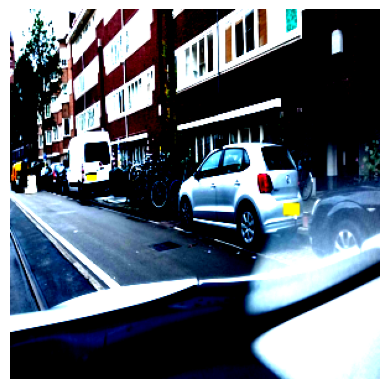

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class name for the selected image: litter
Label index: 3


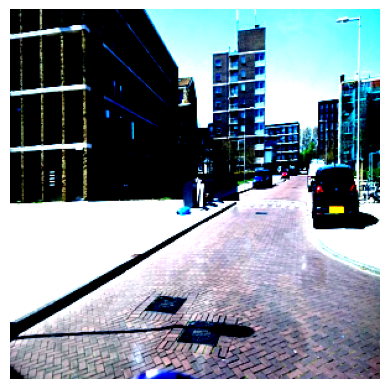

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class name for the selected image: bulkywaste
Label index: 0


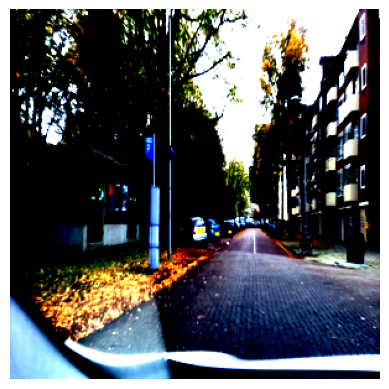

Class name for the selected image: litter
Label index: 3


In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

# Define transforms for data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to the input size expected by the models
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Define paths to train and test directories
train_dir = r"C:\Users\Dell\Downloads\Data_cleaned_multi\test" # Path to the directory containing train data
test_dir = r"C:\Users\Dell\Downloads\Data_cleaned_multi\test"   # Path to the directory containing test data

# Create ImageFolder instances for train and test datasets
train_dataset2 = ImageFolder(root=train_dir, transform=transform)
test_dataset2 = ImageFolder(root=test_dir, transform=transform)

# Define batch size
batch_size = 32  # You can adjust this based on your available memory and batch size preference

# Create DataLoader instances for train and test datasets
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

# Print information about the first batch of training data
for inputs, labels in train_loader2:
    print('name:', inputs)
    print('label:', labels)
    batch_size, channels, height, width = inputs.size()
    print("Input batch dimensions:", batch_size, channels, height, width)
    print("Label batch dimensions:", labels.size())
    
    # Function to get class name from label index
    def get_class_name(label_index):
        for class_name, index in train_dataset2.class_to_idx.items():
            if index == label_index:
                return class_name

    # Print information about the first sample image from the training DataLoader
    for i in range(min(batch_size, 3)):  # Adjust 3 to display desired number of samples
        image = inputs[i]  # Get the i-th image from the batch

        # Convert the tensor image to numpy array and transpose the dimensions
        image = np.transpose(image.numpy(), (1, 2, 0))

        # Display the image
        plt.imshow(image)
        plt.axis('off')
        plt.show()

        # Get the label index of the i-th image and retrieve the corresponding class name
        label_index = labels[i].item()
        class_name = get_class_name(label_index)

        print("Class name for the selected image:", class_name)
        print("Label index:", label_index)
    break  # Break after printing the first batch


# GCDN NET(MULTI LABEL)

In [5]:
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)

        # Replace the classification layers of both models
        num_features_densenet = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features_densenet, num_classes)

        num_features_inception = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_features_inception, num_classes)

        # Combine the outputs of both models
        self.fc_combined = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        output_densenet = self.densenet(x)
        output_inception = self.inception(x)

        # Access the logits tensor from the InceptionV3 model outputs
        output_inception = output_inception.logits

        # Combine the outputs
        combined_output = torch.cat((output_densenet, output_inception), dim=1)
        output = self.fc_combined(combined_output)
        return output
    
num_classes = 4  # Number of classes in your dataset
combined_model_multi = CombinedModel(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model_multi.parameters(), lr=0.001)


C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the 

In [5]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_model_multi.to(device) 
# Number of epochs
combined_model_multi.train() 
num_epochs = 5

# Train the model
for epoch in range(num_epochs):
     # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Create a tqdm progress bar
    progress_bar = tqdm(train_loader2, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    
    for inputs, labels in progress_bar:
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = combined_model_multi(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Update progress bar with loss and accuracy
        progress_bar.set_postfix({'Loss': running_loss / total_predictions, 'Accuracy': correct_predictions / total_predictions})
    
    epoch_loss = running_loss / len(train_loader2.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
torch.save(combined_model_multi.state_dict(), 'multilabel.pth')
    



Epoch [1/5], Loss: 1.2713, Accuracy: 0.4094


Epoch [2/5], Loss: 1.1457, Accuracy: 0.4983


Epoch [3/5], Loss: 1.0608, Accuracy: 0.5235


Epoch [4/5], Loss: 0.9652, Accuracy: 0.5554


Epoch [5/5], Loss: 0.8174, Accuracy: 0.6426


In [34]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
class Inceptionv3Net(nn.Module):
    def __init__(self, num_classes):
        super(Inceptionv3Net, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)

        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)
        print('features',num_features)
        num_features_inception = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_features_inception, num_classes)
        print('features',num_features_inception)

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        return self.inception(x)

#model creation
modeli = Inceptionv3Net(num_classes=2)  # Assuming binary classification

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modeli.parameters(), lr=0.001)


features 1920
features 2048


In [9]:
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)

        # Replace the classification layers of both models
        num_features_densenet = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features_densenet, num_classes)

        num_features_inception = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_features_inception, num_classes)

        # Combine the outputs of both models
        self.fc_combined = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        output_densenet = self.densenet(x)
        output_inception = self.inception(x)

        # Combine the outputs
        combined_output = torch.cat((output_densenet, output_inception), dim=1)
        output = self.fc_combined(combined_output)
        return output


# EVALUATION(MULTI LABEL)

tensor([[[[1.4954, 1.5639, 1.5639,  ..., 0.9474, 0.9474, 0.9817],
          [1.5125, 1.5125, 1.5125,  ..., 1.0331, 0.9646, 0.9646],
          [1.4612, 1.4269, 1.4269,  ..., 1.1015, 0.9988, 0.8789],
          ...,
          [0.6734, 0.6734, 0.6221,  ..., 0.6734, 0.7419, 0.7762],
          [0.6734, 0.6221, 0.5707,  ..., 0.6734, 0.7419, 0.7933],
          [0.6221, 0.5878, 0.4851,  ..., 0.7248, 0.7077, 0.7762]],

         [[1.7108, 1.7808, 1.7808,  ..., 1.0105, 1.0105, 1.0805],
          [1.7283, 1.7283, 1.7283,  ..., 1.1155, 1.0280, 1.0455],
          [1.6758, 1.6408, 1.6408,  ..., 1.2381, 1.0630, 0.9055],
          ...,
          [0.9930, 0.9930, 0.9405,  ..., 0.8004, 0.8880, 0.9230],
          [0.9755, 0.9405, 0.8880,  ..., 0.8004, 0.8880, 0.9405],
          [0.9230, 0.9055, 0.8004,  ..., 0.8704, 0.8529, 0.9230]],

         [[2.0125, 2.0823, 2.0997,  ..., 1.1585, 1.1411, 1.2282],
          [2.0300, 2.0300, 2.0300,  ..., 1.3328, 1.1759, 1.1759],
          [1.9777, 1.9428, 1.9428,  ..., 1

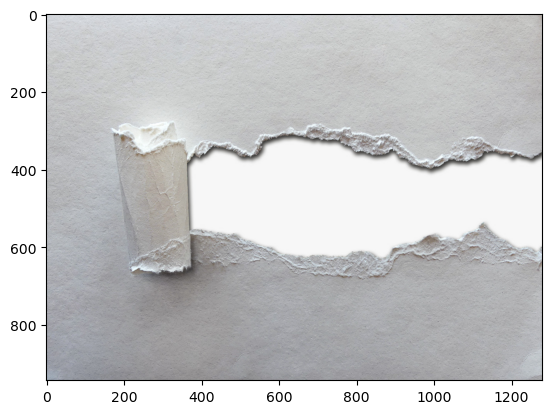

In [65]:
def evaluate_image1(model, image_path, transform):
    model.load_state_dict(torch.load('inceptionv3_model.pth'))

# Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Preprocess the input image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    print(image_tensor)
    plt.imshow(image)
    with torch.no_grad():
        outputs = model(image_tensor)

    _, predicted_idx = torch.max(outputs, 1)
    predicted_idx = predicted_idx.item()  # Extract the index value from the tensor
    
    class_names = ['garbage', 'nongarbarge']  
    predicted_class = class_names[predicted_idx]

    return predicted_class

#input images
image_path = r"C:\Users\Dell\Downloads\xyz.jpg"
predicted_class = evaluate_image1(modeli, image_path, transform)
print(f"Predicted Class: {predicted_class}")

In [72]:
import torch
from torchvision import transforms
from PIL import Image

# Define transformations to be applied to the input image
def multi_eval(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Define class names
    class_names = ['bulkywaste', 'cardboard', 'garbagebag', 'litter']

    # Load the model
    model_path = 'multilabel.pth'
    combined_model_multi = CombinedModel(num_classes)
    combined_model_multi.load_state_dict(torch.load(model_path))
    combined_model_multi.eval()

    # Load the image
    #image_path = r"C:\Users\Dell\Downloads\base\ij.jpg"
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)
    combined_model_multi = combined_model_multi.to(device)

    # Perform inference
    with torch.no_grad():
        output = combined_model_multi(input_batch)

    # Apply softmax to get probabilities
    probabilities = torch.softmax(output, dim=1)

    k = 3  
    topk_probabilities, topk_indices = torch.topk(probabilities, k, dim=1)

    for i in range(input_batch.size(0)):
        print(f"Top predictions for image {i + 1}:")
        for j in range(k):
            class_idx = topk_indices[i, j].item()
            class_probability = topk_probabilities[i, j].item()
            class_name = class_names[class_idx]
            if class_probability>0.01:
                print(f"  {class_name}")

image_path=r"C:\Users\Dell\Downloads\base\gh.jpg"
multi_eval(image_path)


Top predictions for image 1:
  litter
